In [1]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

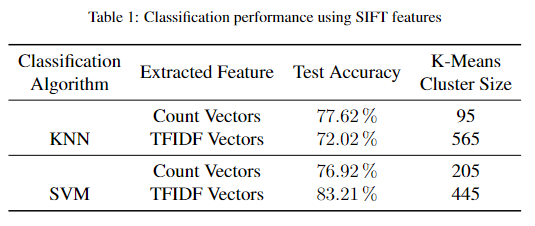

load paths

In [2]:
path = "../Models and Data/K_Cluster_Extracted_Features/"
k_clusters = [95, 205, 445, 565]
model_paths_count = np.array([path + f"Extracted_{x}/count_vectors_{x}.npy" for x in k_clusters]).flatten()
model_paths_tfidf = np.array([path + f"Extracted_{x}/tfidf_vectors_{x}.npy" for x in k_clusters]).flatten()

model_paths_count, model_paths_tfidf

(array(['../Models and Data/K_Cluster_Extracted_Features/Extracted_95/count_vectors_95.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_205/count_vectors_205.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_445/count_vectors_445.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_565/count_vectors_565.npy'],
       dtype='<U83'),
 array(['../Models and Data/K_Cluster_Extracted_Features/Extracted_95/tfidf_vectors_95.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_205/tfidf_vectors_205.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_445/tfidf_vectors_445.npy',
        '../Models and Data/K_Cluster_Extracted_Features/Extracted_565/tfidf_vectors_565.npy'],
       dtype='<U83'))

train test split extracted features from .npy files

In [3]:
from sklearn.model_selection import train_test_split

def read_features(path: str) -> [np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    # convert labels to binary 1 or 0
    def encode(img_class: str) -> int:
        if(img_class == "Pothole"):
            return 1
        return 0
    
    # load data and convert sparse matrix to dense
    data = np.load(path, allow_pickle=True).item()
    data = data.toarray()

    # load class data
    classes = np.load("../Models and Data/K_Cluster_Extracted_Features/Image_Classes.npy", allow_pickle=True)
    classes = np.array([encode(x) for x in classes])

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(data, classes, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

create FFNN from array an like description

In [4]:
def createFFNN(feature_size: int, hidden_layers: list, activation_function: list, learning_rate: float):
    model = models.Sequential()

    for i in range(len(hidden_layers)):
        # if it is the first layer, then input dim is feature size, else it is the previous hidden layer size
        model.add(layers.Dense(input_dim = feature_size if i == 0 else hidden_layers[i-1],
                               units=hidden_layers[i],
                               activation=activation_function[i]))
        
    model.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy'])
    
    return model

train FFNN and plot results

In [5]:
import matplotlib.pyplot as plt

def trainFFNN(model: models.Sequential, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, epochs: int, batch_size: int, figTitle: str):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    max_train_acc_epoch = np.argmax(history.history['accuracy'])
    max_test_acc_epoch = np.argmax(history.history['val_accuracy'])

    plt.figure(figsize=(12, 6))
    plt.suptitle(figTitle)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')

    plt.scatter(max_train_acc_epoch, history.history['loss'][max_train_acc_epoch], color='r', marker='o')
    plt.text(max_train_acc_epoch, history.history['loss'][max_train_acc_epoch], f'{history.history["loss"][max_train_acc_epoch]:.3f}', ha='right', va='bottom', color='r')
    plt.scatter(max_test_acc_epoch, history.history['val_loss'][max_test_acc_epoch], color='b', marker='o')
    plt.text(max_test_acc_epoch, history.history['val_loss'][max_test_acc_epoch], f'{history.history["val_loss"][max_test_acc_epoch]:.3f}', ha='right', va='bottom', color='b')

    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.scatter(max_train_acc_epoch, history.history['accuracy'][max_train_acc_epoch], color='r', marker='o')
    plt.text(max_train_acc_epoch, history.history['accuracy'][max_train_acc_epoch], f'{history.history["accuracy"][max_train_acc_epoch]*100:.2f}%', ha='right', va='bottom', color='r')
    plt.scatter(max_test_acc_epoch, history.history['val_accuracy'][max_test_acc_epoch], color='b', marker='o')
    plt.text(max_test_acc_epoch, history.history['val_accuracy'][max_test_acc_epoch], f'{history.history["val_accuracy"][max_test_acc_epoch]*100:.2f}%', ha='right', va='bottom', color='b')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## TFIDF Vectors FFNN config

(This is the best config I could find using trial and error that wont overfit much)

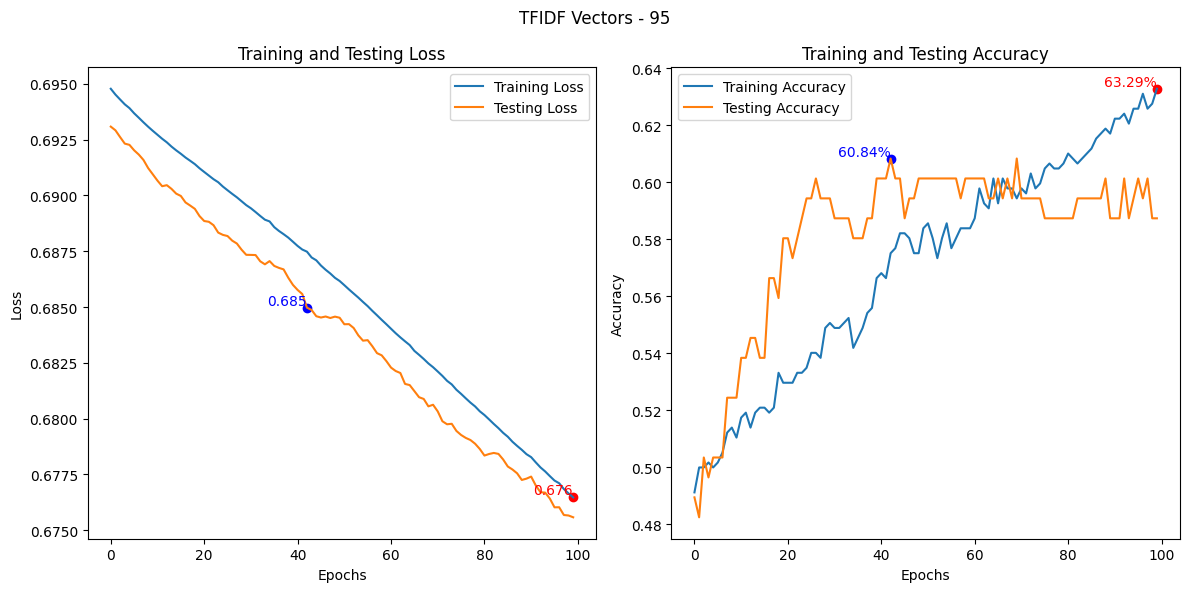

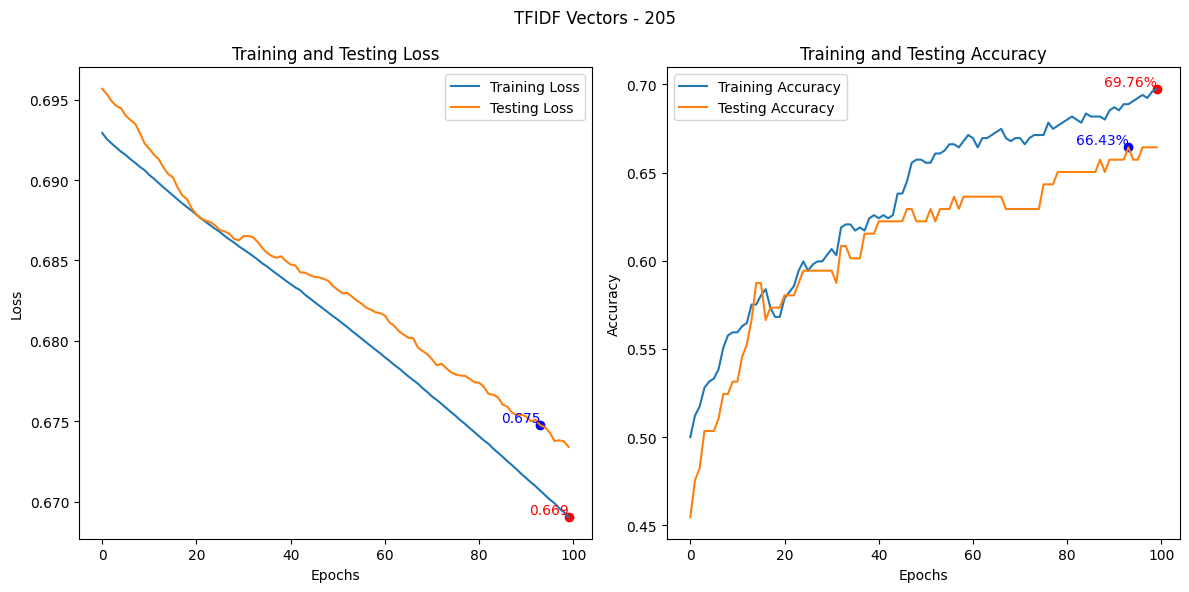

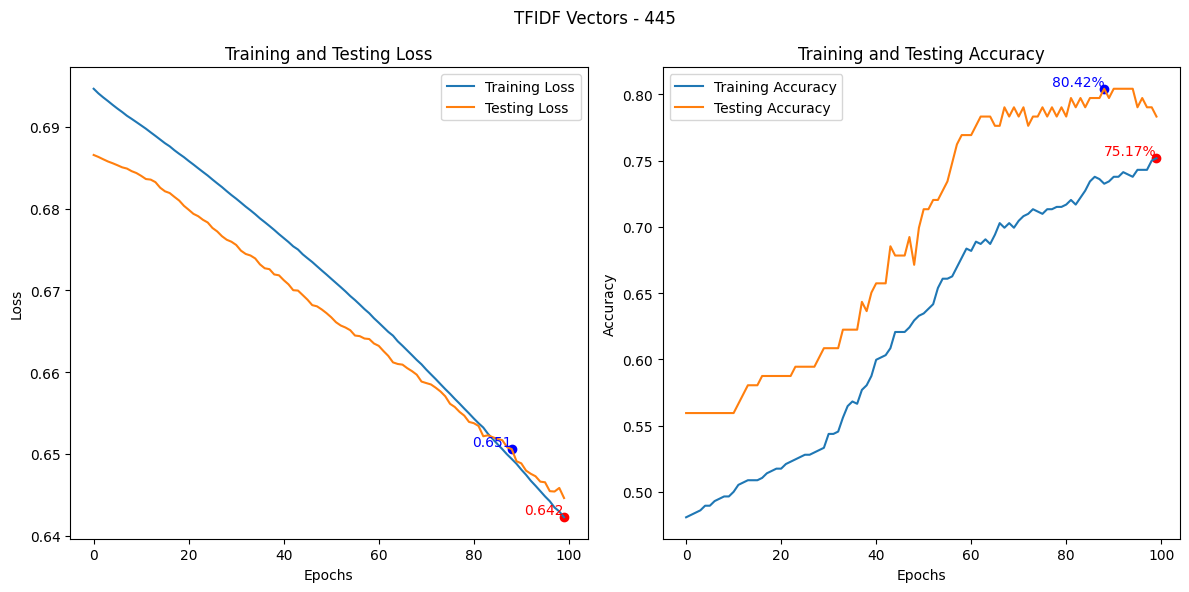

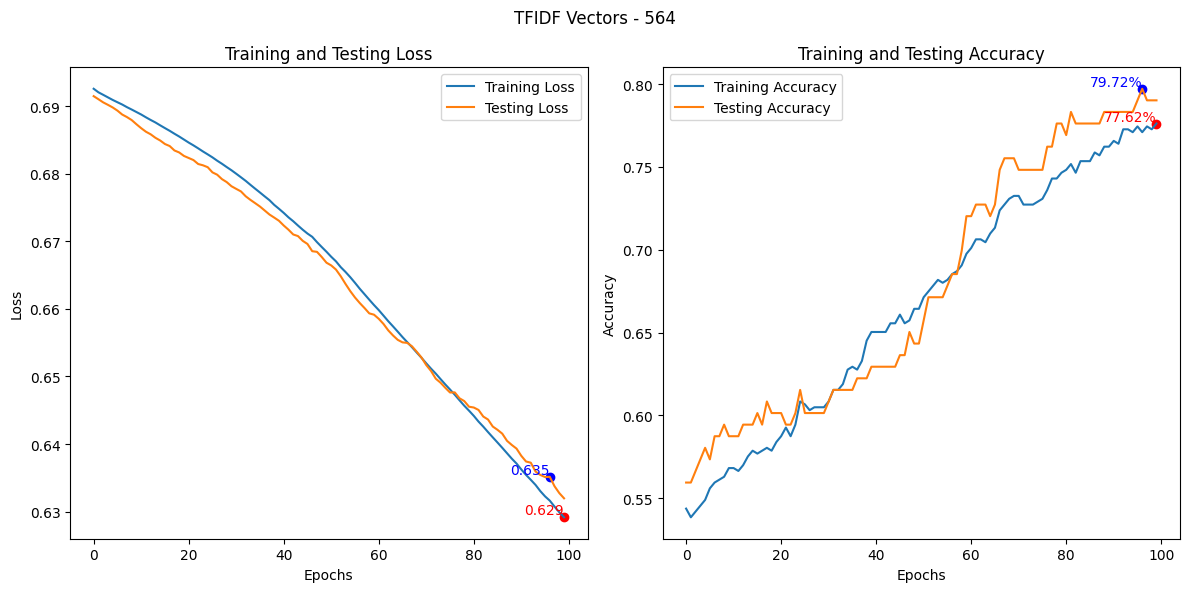

In [6]:
hidden_layers = [9, 1]
activation_function = ['relu', 'sigmoid']
learning_rate = 0.0001
epochs = 100
batch_size = 50

K_Cluster_Sizes = [95, 205, 445, 564]

for i in range(len(model_paths_tfidf)):
    X_train, X_test, y_train, y_test = read_features(model_paths_tfidf[i])
    model = createFFNN(feature_size=K_Cluster_Sizes[i], hidden_layers=hidden_layers, activation_function=activation_function, learning_rate=learning_rate)
    trainFFNN(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs, batch_size=batch_size, figTitle=f"TFIDF Vectors - {K_Cluster_Sizes[i]}")

## Count Vectors FFNN config

model overfits with higher feature size even with the simplest architecture

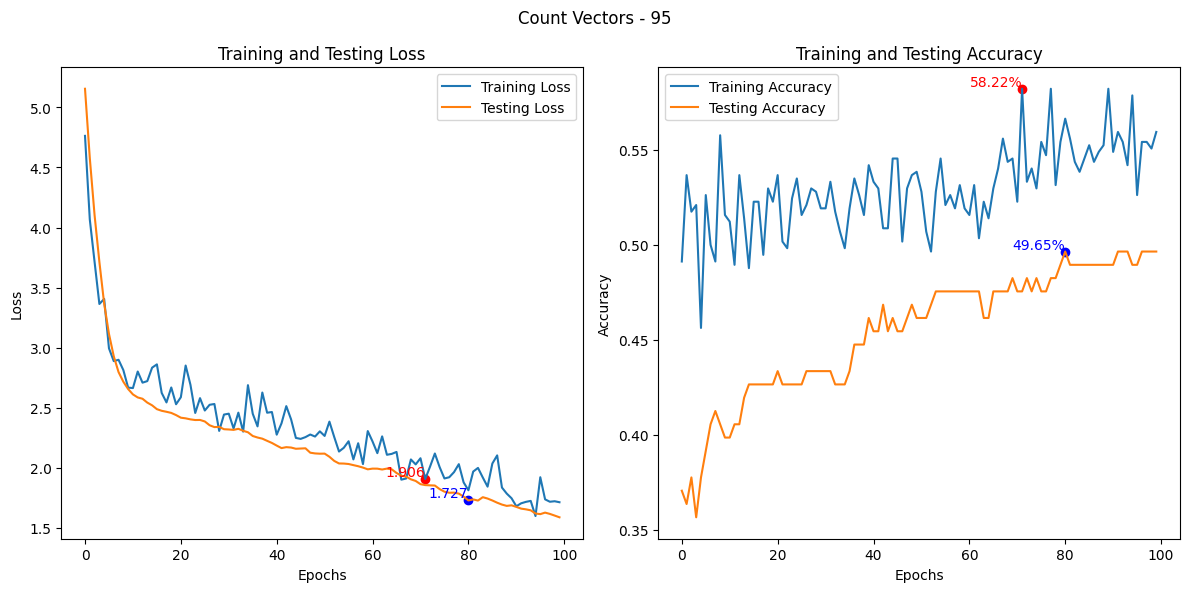

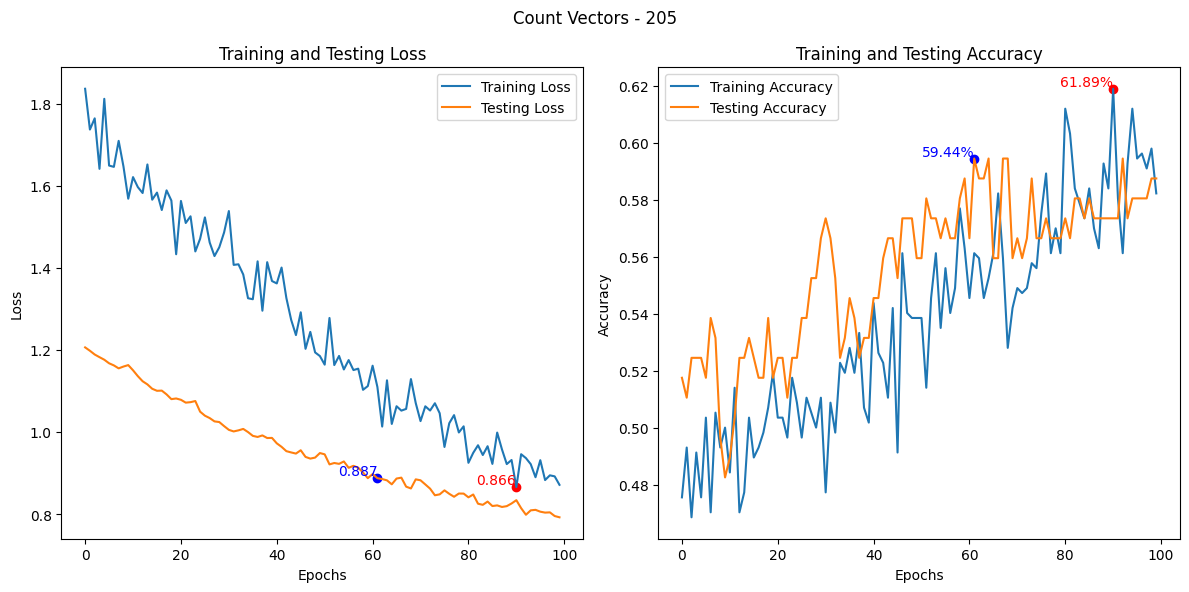

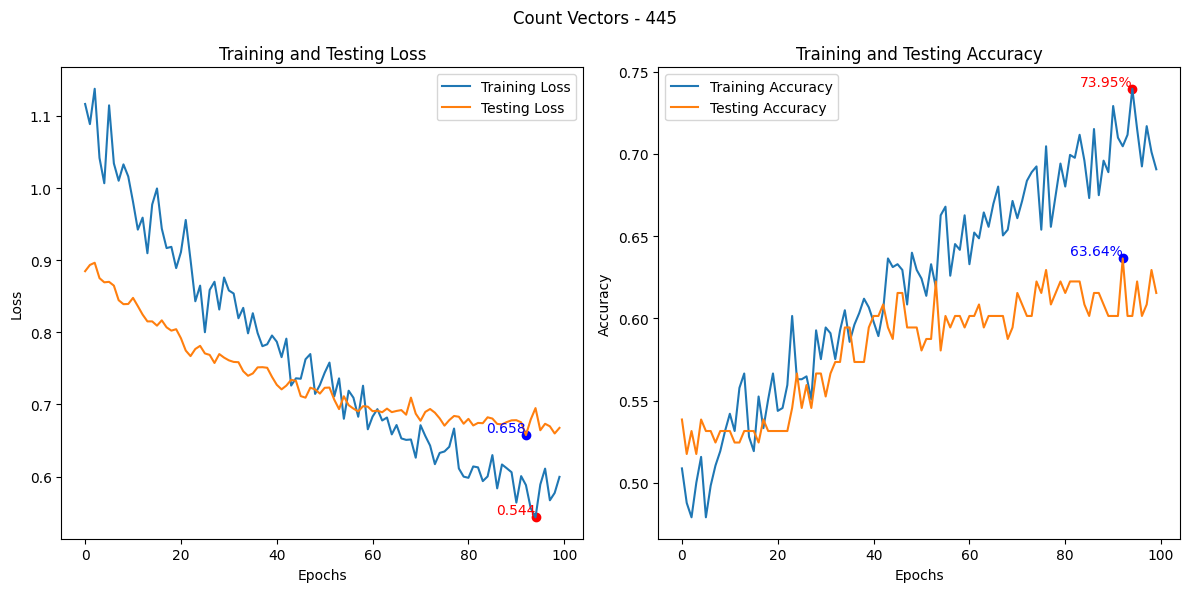

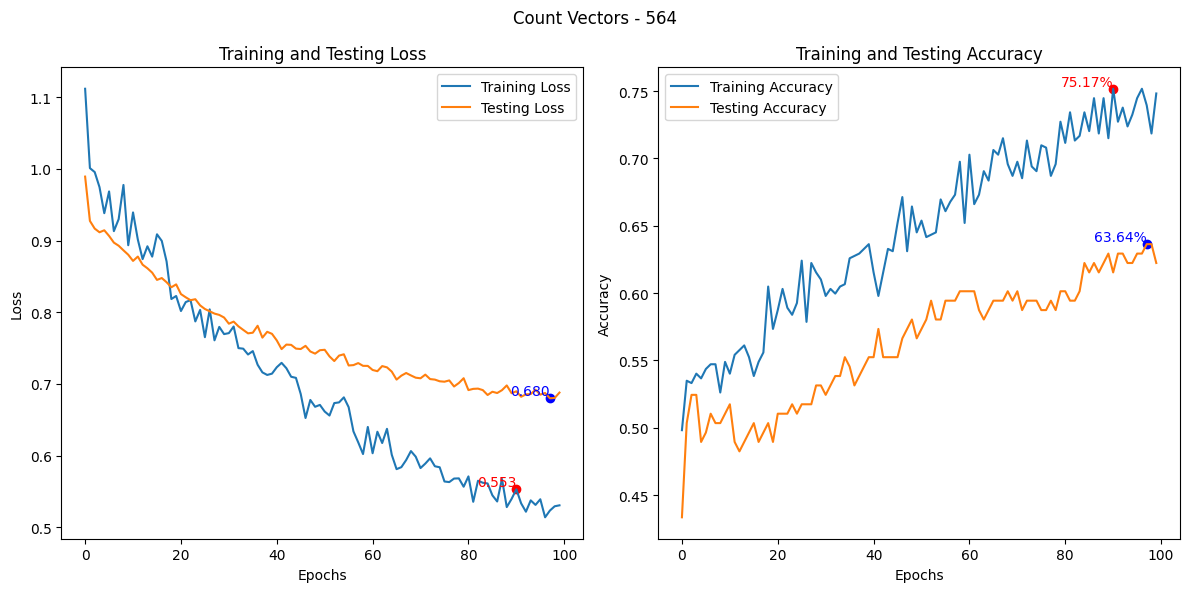

In [12]:
learning_rate = 0.00021
epochs = 100
batch_size = 50

K_Cluster_Sizes = [95, 205, 445, 564]


def createFFNN_2(feature_size: int, learning_rate: learning_rate):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(feature_size,)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])
    return model

for i in range(len(model_paths_count)):
    X_train, X_test, y_train, y_test = read_features(model_paths_count[i])
    model = createFFNN_2(feature_size=K_Cluster_Sizes[i], learning_rate=learning_rate)
    trainFFNN(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs, batch_size=batch_size, figTitle=f"Count Vectors - {K_Cluster_Sizes[i]}")